In [2]:
import sys

sys.path.append("..")

In [3]:
import os

import cv2 as cv

In [4]:
folder_normal_image_name = "../data/clear_and_cropped_image_data/normal/"
folder_malignant_image_name = "../data/clear_and_cropped_image_data/malignant/"

normal_image_names = os.listdir(folder_normal_image_name)
malignant_image_names = os.listdir(folder_malignant_image_name)

normal_image_paths = [folder_normal_image_name + path for path in os.listdir(folder_normal_image_name)]
malignant_image_paths = [folder_malignant_image_name + path for path in os.listdir(folder_malignant_image_name)]

In [5]:
import numpy as np
import pandas as pd

In [6]:
from src.feature_extraction.extract_figure_features import extract_figure_features

figure_features = extract_figure_features()

In [7]:
figure_features["106_2"]

{'figure_0_contrast': 0.014818127608825275,
 'figure_45_contrast': 0.033476014171745234,
 'figure_90_contrast': 0.030561082371667353,
 'figure_135_contrast': 0.032020968601910525,
 'figure_0_dissimilarity': 0.007036374478234939,
 'figure_45_dissimilarity': 0.014241507666395939,
 'figure_90_dissimilarity': 0.013539594110624767,
 'figure_135_dissimilarity': 0.01397242389663198,
 'figure_0_homogeneity': 0.9970874616271108,
 'figure_45_homogeneity': 0.9945286958544499,
 'figure_90_homogeneity': 0.9947241065424652,
 'figure_135_homogeneity': 0.9945998014954003,
 'figure_0_asm': 0.9770391630058006,
 'figure_45_asm': 0.9766848114633171,
 'figure_90_asm': 0.97688358597371,
 'figure_135_asm': 0.9767143454444862,
 'figure_0_energy': 0.9884529139042489,
 'figure_45_energy': 0.9882736521142902,
 'figure_90_energy': 0.9883742135313476,
 'figure_135_energy': 0.9882885942094476,
 'figure_0_correlation': 0.958522590435815,
 'figure_45_correlation': 0.9065549081627301,
 'figure_90_correlation': 0.91454

In [8]:
from scipy.stats import kurtosis, skew
from skimage.feature import graycomatrix, graycoprops

In [9]:
def get_glcm_matrix_features(image, label):
    result = {}
    image = (image / 16).astype(np.uint8)

    distances = [1]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    glcm = graycomatrix(image, distances, angles, levels=16, symmetric=True, normed=True)

    glcm_stats = {
        "contrast": graycoprops(glcm, "contrast"),
        "dissimilarity": graycoprops(glcm, "dissimilarity"),
        "homogeneity": graycoprops(glcm, "homogeneity"),
        "asm": graycoprops(glcm, "ASM"),
        "energy": np.sqrt(graycoprops(glcm, "ASM")),
        "correlation": graycoprops(glcm, "correlation"),
    }
    for name, stat in glcm_stats.items():
        result[f"{label}_0_{name}"] = stat[0][0]
        result[f"{label}_45_{name}"] = stat[0][1]
        result[f"{label}_90_{name}"] = stat[0][2]
        result[f"{label}_135_{name}"] = stat[0][3]
    return result

In [10]:
def extract_image_feature(image, label):
    result = {
        f"{label}_mean": image.mean(),
        f"{label}_std": image.std(),
        f"{label}_min": image.min(),
        f"{label}_max": image.max(),
        f"{label}_median": np.median(image),
        f"{label}_skewness": skew(image.flatten()),
        f"{label}_kurtosis": kurtosis(image.flatten(), fisher=True),
    }

    quantile_steps = np.arange(0.05, 1.0, 0.05)
    quantiles = np.quantile(image, quantile_steps)
    for i, quantile in enumerate(quantiles):
        result[f"{label}_{i + 1}_quantile"] = quantile

    result.update(get_glcm_matrix_features(image, label))

    return result

In [11]:
all_image_paths = normal_image_paths + malignant_image_paths
all_image_name = normal_image_names + malignant_image_names

features = []

for i, image_path in enumerate(all_image_paths):
    image_number = all_image_name[i][all_image_name[i].find("_") + 1 : all_image_name[i].rfind(".")]
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    blurred_image = cv.GaussianBlur(image, (5, 5), 1.4)

    equalized_image = cv.equalizeHist(image)

    curr_image_features = {"name": image_number}
    curr_image_features.update(extract_image_feature(image, "default"))

    curr_image_features.update(extract_image_feature(blurred_image, "blur"))

    curr_image_features.update(extract_image_feature(equalized_image, "equalized"))

    sobel_x = cv.Sobel(blurred_image, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(blurred_image, cv.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv.convertScaleAbs(sobel_x)
    abs_sobel_y = cv.convertScaleAbs(sobel_y)
    sobel_grad = cv.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    curr_image_features.update(extract_image_feature(sobel_grad, "sobel"))

    laplacian = cv.Laplacian(blurred_image, cv.CV_64F).astype(np.uint8)
    curr_image_features.update(extract_image_feature(laplacian, "laplacian"))

    sigma = 0.9
    v = np.median(blurred_image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    canny = cv.Canny(blurred_image, lower, upper, L2gradient=True)
    curr_image_features.update(extract_image_feature(canny, "canny"))

    curr_image_features.update(figure_features[image_number])

    if image_path in normal_image_paths:
        curr_image_features["target"] = 0
    else:
        curr_image_features["target"] = 1

    features.append(curr_image_features)

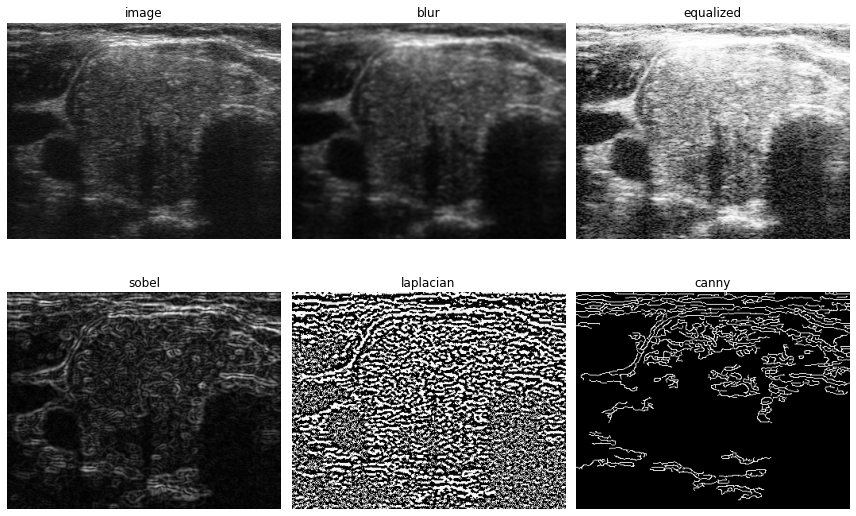

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

image = cv.imread(normal_image_paths[20], cv.IMREAD_GRAYSCALE)

blurred = cv.GaussianBlur(image, (5, 5), 1.4)

equalized_image = cv.equalizeHist(image)

sobel_x = cv.Sobel(blurred, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(blurred, cv.CV_64F, 0, 1, ksize=3)
abs_sobel_x = cv.convertScaleAbs(sobel_x)
abs_sobel_y = cv.convertScaleAbs(sobel_y)
grad = cv.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

laplacian = cv.Laplacian(blurred, cv.CV_64F).astype(np.uint8)

sigma = 0.9
v = np.median(blurred)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
canny = cv.Canny(blurred, lower, upper, L2gradient=True)

images = [image, blurred, equalized_image, grad, laplacian, canny]
titles = ["image", "blur", "equalized", "sobel", "laplacian", "canny"]
for ax, img, title in zip(axes.flatten(), images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

# axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [13]:
df = pd.DataFrame(features)
df.head()

,name,default_mean,default_std,default_min,default_max,default_median,default_skewness,default_kurtosis,default_1_quantile,default_2_quantile,...,figure_mean,figure_area,figure_max,figure_min,figure_std,figure_perimeter,figure_skewness,figure_median,figure_kurtosis,target
0,69_2,88.001217,38.134743,13,255,83.0,0.933868,1.409521,35.0,43.0,...,72.027110,2287,183,18,23.668996,180.076865,1.692969,68.0,4.578270,0
1,380_1,82.335703,41.009582,7,255,79.0,0.650147,0.397588,24.0,29.0,...,71.692199,57235,249,9,32.342588,913.065723,0.349716,72.0,0.060053,0
2,158_2,97.597160,43.821470,7,255,90.0,0.895270,0.647084,40.0,48.0,...,75.991837,6248,216,29,24.794651,299.780540,1.878780,71.0,5.121252,0
3,66_1,78.756686,31.397057,9,245,75.0,0.704825,0.662901,35.0,41.0,...,63.814262,12523,173,11,22.628529,557.980631,0.597191,61.0,0.136921,0
4,69_3,93.166859,37.735053,12,255,92.0,0.394197,0.062712,35.0,43.0,...,82.739580,2903,189,19,23.651310,210.073542,0.327607,82.0,0.276633,0


In [14]:
df.shape

(301, 354)

In [15]:
df["target"].value_counts()

target
1    193
0    108
Name: count, dtype: int64

In [16]:
len(normal_image_names), len(malignant_image_names)

(108, 193)

In [17]:
df.isna().sum()

name                0
default_mean        0
default_std         0
default_min         0
default_max         0
                   ..
figure_perimeter    0
figure_skewness     0
figure_median       0
figure_kurtosis     0
target              0
Length: 354, dtype: int64

In [18]:
df.to_csv(
    "/home/kush/machine_learning/ClassificationThyroidDiseases_ByUltrasoundImage/data/total_data.csv", index=False
)